In [1]:
# import sys
# sys.path.append("../../")
import libspn as spn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

# Params

### Structure

In [2]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGeneratorLayerNodes.InputDist.RAW

num_decomps=1
num_subsets=5
num_mixtures=2

# Number of input mixtures for dense generator
num_input_mixtures = 2

### Learning

In [3]:
# Additive smoothing during learning
additive_smoothing=100
min_additive_smoothing=1
smoothing_decay=0.2

# Weight initialization
# weight_init_value = 1
weight_init_value = 1.0

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Training Set

In [4]:
datasets = tf.contrib.learn.datasets.mnist.read_data_sets("/home/jos/datasets/mnist")

Extracting /home/jos/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/jos/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [5]:
def show_mnist(img):
    img=np.reshape(img, (14,14))
    plt.imshow(img, interpolation='none', cmap="gray")
    plt.show()

### Process data

In [6]:
def process_set(data):
#     threshold = 20
    images = np.reshape(data, (-1, 28,28))
    resized=[]
    for i in range(images.shape[0]):
        resized.append((scp.misc.imresize(images[i, :, :], 0.5).ravel()))
    images=np.vstack((resized - np.mean(resized)) / np.std(resized))
    return images

In [7]:
train_images = process_set(datasets.train.images)
test_images = process_set(datasets.test.images)
train_labels = datasets.train.labels
test_labels = datasets.test.labels
validation_labels = datasets.validation.labels

/home/jos/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


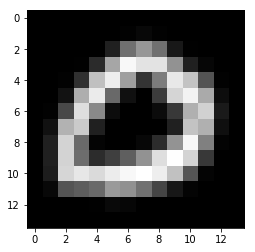

In [8]:
show_mnist(train_images[19])

In [9]:
train_images_0 = train_images[train_labels==0]
train_images_1 = train_images[train_labels==1]
test_images_0 = test_images[test_labels==0]
test_images_1 = test_images[test_labels==1]

(5444, 196)


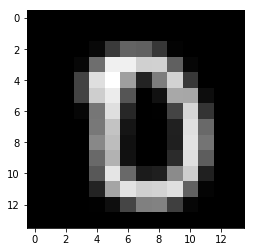

(6179, 196)


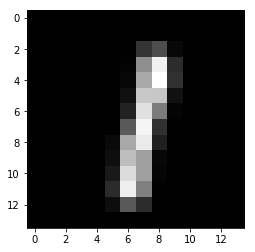

(980, 196)


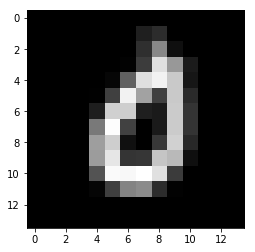

(1135, 196)


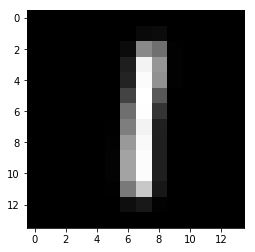

In [10]:
print(train_images_0.shape)
show_mnist(train_images_0[334])
print(train_images_1.shape)
show_mnist(train_images_1[22])
print(test_images_0.shape)
show_mnist(test_images_0[334])
print(test_images_1.shape)
show_mnist(test_images_1[22])

# Generate SPN structure
It is difficult to understand the likelihood drop when jointly training weights, means and variances if one initializes the means and variances using the method described in the paper by Poon and Domingos (2012). Things that have been considered
- `MIXTURE` vs. `RAW`
- Initializing weights to 1 instead of random
- Initial accumulator value
- Turning off learning only for variances

In [11]:
tf.reset_default_graph()
train_set = np.concatenate([train_images_0, train_images_1], 0)
gauss_quantiles = spn.GaussianLeaf(num_vars=196, num_components=4, data=train_set, total_counts_init=1.0,
                                  learn_dist_params=True, train_var=True, train_mean=True, learn_scale=True, 
                                  use_prior=True, min_stddev=1e-8, prior_alpha=1.0, prior_beta=1.0)
# gauss_quantiles.learn_from_data(train_images)
dense_gen = spn.DenseSPNGeneratorLayerNodes(num_decomps=num_decomps, num_subsets=num_subsets, num_mixtures=num_mixtures, 
                                            input_dist=input_dist, num_input_mixtures=num_input_mixtures)
root0 = dense_gen.generate(gauss_quantiles)
root1 = dense_gen.generate(gauss_quantiles)
root = spn.Sum(root0, root1)
spn.generate_weights(root, init_value=weight_init_value)
latent = root.generate_ivs()
print(root.get_num_nodes())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:443: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


616


# Add Learning Ops

In [12]:
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          use_unweighted=True, initial_accum_value=1.0)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/utils/math.py:509: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Use the `axis` argument instead


[WARNING] [tensorflow:warning] From /home/jos/spn/libspn/libspn/graph/sum.py:300: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


# Run Training

In [13]:
sess=None #https://github.com/whsu/spn/tree/master/spn

In [14]:
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

writer = tf.summary.FileWriter("tflogs_mnist_continuous")

summarize_mean = tf.summary.histogram("GaussianLeafMeans", gauss_quantiles.mean_variable)
summarize_variance = tf.summary.histogram("GaussianLeafVariances", gauss_quantiles.variance_variable)

# weights = tf.get_collection('spn_weights')
# # summarize_weights = tf.summary.histogram("Weights", tf.concat(weights, axis=0))
# weight_maxes = [tf.reduce_max(w) for w in weights]
# weight_dominances = [(tf.reduce_sum(w) - m) / (m + 1e-10) for w, m in zip(weights, weight_maxes)]
# weight_dom = tf.summary.histogram("WeightDominance", tf.stack(weight_dominances))
# sparseness = tf.summary.scalar("SparsenessMixtureCounts", tf.reduce_mean(
#     tf.cast(tf.equal(learning._mpe_path.counts[gauss_quantiles], 0), tf.float32)))
merged = tf.summary.merge([summarize_mean, summarize_variance])

In [15]:
train_set = np.concatenate([train_images_0, train_images_1], 0)
train_labels = np.concatenate([np.ones((train_images_0.shape[0]))*0, 
                               np.ones((train_images_1.shape[0]))*1])
train_labels=np.reshape(train_labels, (-1, 1))

if sess is not None:
    sess.close()

sess = tf.Session()

sess.run(init_weights)
sess.run(reset_accumulators)

num_batches=8
batch_size = train_set.shape[0] // num_batches
prev_likelihood = 100
likelihood = 0
epoch = 0

accumulators = [node.accum for node in learning._gaussian_leaf_nodes]
sum_data = [node.sum_data for node in learning._gaussian_leaf_nodes]
sum_data_squared = [node.sum_data_squared for node in learning._gaussian_leaf_nodes]

mean_history = []
variance_history = []

data_per_component = [[(list(), list()) for _ in range(14)] for _ in range(14)]

while abs(prev_likelihood - likelihood)>0.1:
    prev_likelihood=likelihood
    likelihoods = []
    pbar = tqdm_notebook(range(num_batches))
    train_set, train_labels = shuffle(train_set, train_labels)
    writer.add_summary(sess.run(merged), epoch)
    mn, vr = sess.run([gauss_quantiles.mean_variable, gauss_quantiles.variance_variable])
    mean_history.append(mn)
    variance_history.append(vr)
    for batch in pbar:
        start = (batch)*batch_size
        stop = (batch+1)*batch_size
#         print("EPOCH", epoch, "BATCH", batch, "SAMPLES", start, stop)
        # Adjust smoothing
        ads=max(np.exp(-epoch*smoothing_decay)*additive_smoothing, min_additive_smoothing)
        sess.run(additive_smoothing_var.assign(ads))
#         print("Smoothing: ", sess.run(additive_smoothing_var)) 
        # Run accumulate_updates
        train_likelihoods_arr, avg_train_likelihood_val, _ = \
                sess.run([train_likelihood, avg_train_likelihood, accumulate_updates],
                        feed_dict={gauss_quantiles: train_set[start:stop],
                                   latent: train_labels[start:stop]})
        # Print avg likelihood of this batch data on previous batch weights
#         print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))
        pbar.set_description("Lh {}".format(avg_train_likelihood_val))
        likelihoods.append(avg_train_likelihood_val)
        sess.run(update_spn)
    
    
    likelihood = sum(likelihoods) / len(likelihoods)
    print("Avg likelihood: %s" % (likelihood))
    epoch+=1
    sess.run(reset_accumulators)


Avg likelihood: 308.92448329925537



Avg likelihood: 381.9302864074707



Avg likelihood: 389.2090950012207



Avg likelihood: 390.1938056945801



Avg likelihood: 390.3777503967285



Avg likelihood: 390.99673080444336



Avg likelihood: 391.1540222167969



Avg likelihood: 391.3598747253418



Avg likelihood: 391.4940643310547



Avg likelihood: 391.4997901916504


In [16]:
# %load_ext autoreload

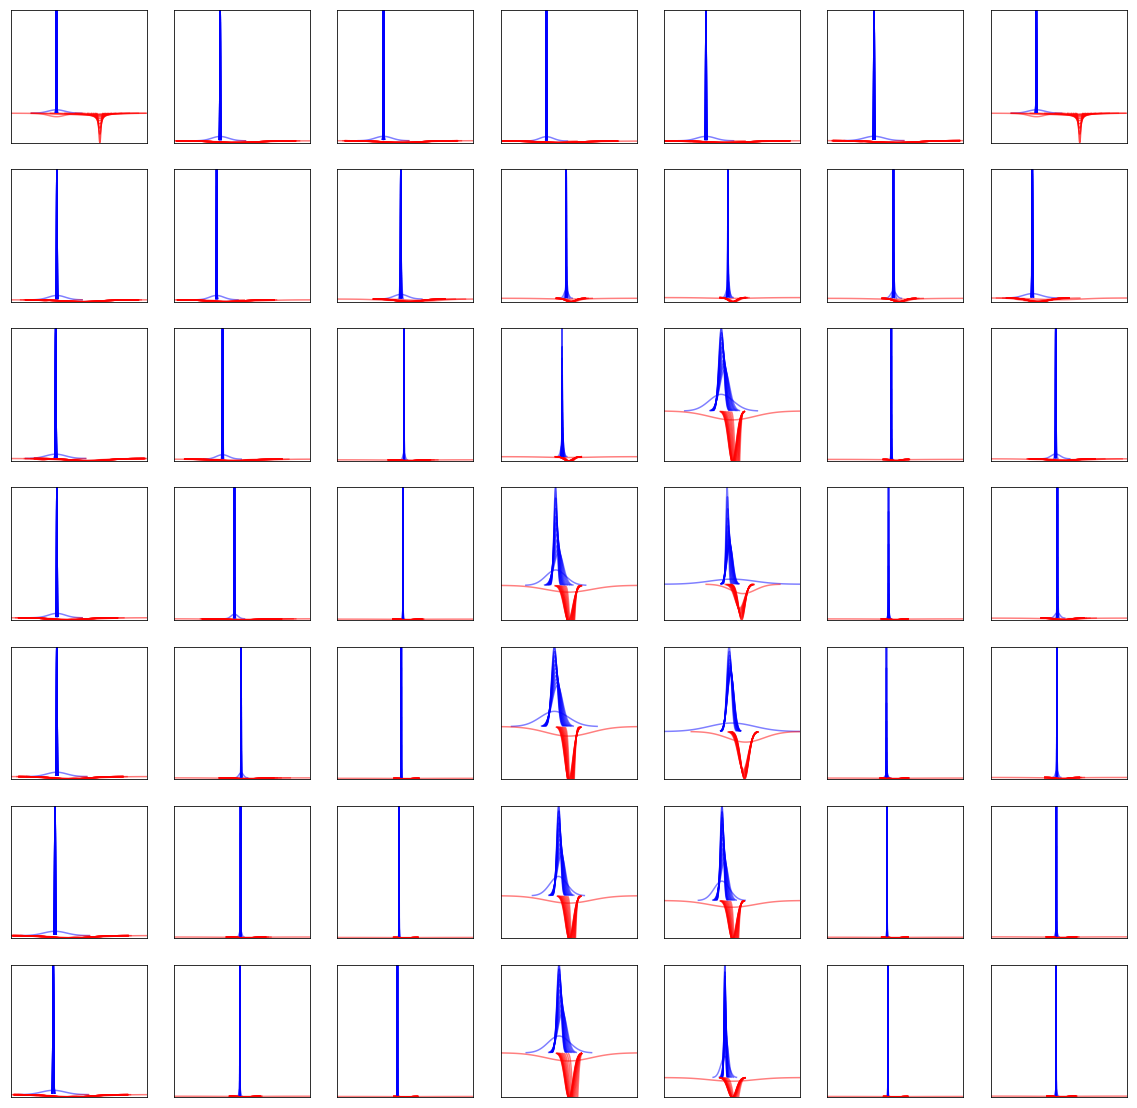

In [27]:
%matplotlib inline
# %autoreload
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d.axes3d import Axes3D
nrows, ncols = 8, 8
fig, axes = plt.subplots(nrows=7, ncols=7)
fig.set_size_inches((20, 20))


for row in range(7):
    for col in range(7):
        var_index = row * 14 + col * 2 #, mixture_index = np.random.randint(14 * 14), np.random.randint(2)
        length = len(mean_history)
        minx, maxx, miny, maxy, minz, maxz = np.inf, -np.inf, np.inf, -np.inf, np.inf, -np.inf
        for t in range(length // 2):
            for mixture_index in [0, 1]:
                mu, sigma = mean_history[t][var_index, mixture_index], variance_history[t][var_index, mixture_index]
                std = np.sqrt(sigma)
                x = np.linspace(mu - 3 * std, mu + 3 * std, 100)
                z = stats.norm(loc=mu, scale=std).pdf(x)
                y = 1 - np.ones(x.shape) * t / length
                minx = min(minx, x.min())
                miny = min(miny, y.min())
                maxx = max(maxx, x.max())
                maxy = max(maxy, y.max())
                z *= 1 if mixture_index == 0 else -1
                minz = min(maxz, z.min())
                maxz = max(maxz, z.max())

                axes[row][col].plot(x, z, 'b-' if mixture_index == 0 else 'r-', alpha=(t + length) / (length * 2))
                
        axes[row][col].set_xticks([], [])
        axes[row][col].set_yticks([], [])
#         axes[row][col].set_zticks([], [])
#         axes[row][col].view_init(30, 280)
        axes[row][col].set_xlim([minx, maxx])
#         axes[row][col].set_ylim([miny, maxy])
        axes[row][col].set_ylim([minz, maxz])
# print(flat_sum_data_sq)
# print(np.unique(flat_accum).size)

# Generate Testing Ops

In [16]:
mpe_state_gen = spn.MPEState(log=True, value_inference_type=spn.InferenceType.MPE)

In [17]:
mpe_gauss_quantiles, mpe_latent = mpe_state_gen.get_state(root, gauss_quantiles, latent)

In [ ]:
# mpe_gauss_quant = tf.where(tf.equal(mpe_latent, 0), mpe_gauss_quantiles0, mpe_gauss_quantiles1)

# Run Testing

### MPE of the whole network

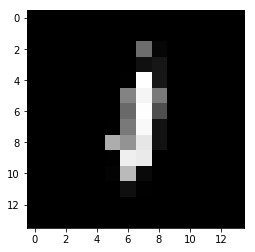

[[1]]


In [18]:
no_evidence = np.zeros((1, 14 * 14)).astype(np.bool) 
mpe_gauss_val, mpe_latent_val = sess.run([mpe_gauss_quantiles, mpe_latent], feed_dict={
    gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[-1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 0

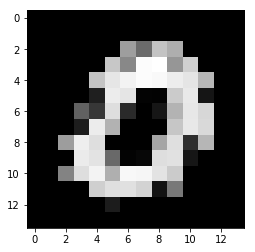

[[0]]


In [19]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[0]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### MPE for 1

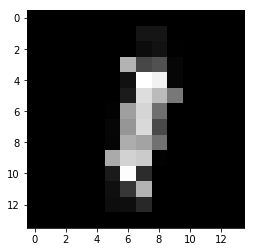

[[1]]


In [32]:
mpe_gauss_val, mpe_latent_val = sess.run(
    [mpe_gauss_quantiles, mpe_latent], feed_dict={gauss_quantiles: np.ones((1, 14*14), dtype=int) * -1, latent: [[1]], gauss_quantiles.evidence: no_evidence})
show_mnist(mpe_gauss_val)
print(mpe_latent_val)

### Classification of Training Data

In [20]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={
    gauss_quantiles: train_set, latent: np.ones((train_set.shape[0], 1))*-1})
result=(mpe_latent_val==train_labels)
np.sum(result) / train_labels.size

0.9967306203217758

### Classification of Test Data

In [21]:
test_set = np.concatenate([test_images_0, test_images_1], 0)
test_labels = np.concatenate([np.ones((test_images_0.shape[0]))*0, 
                               np.ones((test_images_1.shape[0]))*1])
test_labels=np.reshape(test_labels, (-1, 1))

In [22]:
mpe_latent_val = sess.run([mpe_latent], feed_dict={
    gauss_quantiles: test_set, latent: np.ones((test_set.shape[0], 1))*-1})
result=(mpe_latent_val==test_labels)
np.sum(result) / test_labels.size

0.9985815602836879